# <center> Реализация алгоритма построения дерева решений

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [2]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ – критерий разбиения.
    
   пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов -
    наиболее многочисленный класс в листе, в который попал объект.

In [3]:
# Определим критерии качества: 
# энтропийный критерий и критерий Джини
def entropy(y):    
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return -np.dot(p, np.log2(p))

def gini(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(p, p)

criteria_dict = {'entropy': entropy, 'gini': gini}

Класс Node реализует вершину в дереве решений.

In [4]:
class Node():
    
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Определяем функцию для вычисления ответа в листе - наиболее многочисленный класс в листе

In [5]:
def classification_leaf(y):
    return np.bincount(y).argmax()

In [6]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        # Инициализируем объект с помощью метода set_params
        params = {'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'criterion': criterion,
                  'debug': debug}
        
        self.set_params(**params)
        
        if self.debug:
            print("\nDecisionTree params:")
            print("max_depth = {}, min_samples_split = {}, criterion = {}\n"\
                  .format(max_depth, min_samples_split, criterion))
            
    def set_params(self, **params):
        super(DecisionTree, self).set_params(**params)
        
        self._criterion_function = criteria_dict[self.criterion]
        
        if self.criterion in ['variance', 'mad_median']:
            self._leaf_value = regression_leaf
        else:
            self._leaf_value = classification_leaf
        
        return self
            
    
    # Функционал, на основе которого осуществляется разбиение выборки на две части
    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold
        n_obj = X.shape[0]
        n_left = np.sum(mask)
        n_right = n_obj - n_left    
        if n_left > 0 and n_right > 0:
            return self._criterion_function(y) - (n_left / n_obj) * \
                    self._criterion_function(y[mask]) - (n_right / n_obj) * \
                    self._criterion_function(y[~mask])
        else:
            return 0
        
    # Рекурсивная процедура построения дерева решений 
    def _build_tree(self, X, y, depth=1):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape     
        
        
        # Если все объекты в текущей вершине имеют одинаковые значения ответов, 
        # то значение функционала также будет = 0 при всех разбиениях. 
        # Значит, в этом случае вершина - лист, поэтому чтобы не производить
        # лишних вычислений, делаем эту проверку перед основным циклом.
        if len(np.unique(y)) == 1:
            return Node(labels=y)
            
        # Если критерий останова не выполнен, то ищем оптимальное разбиение
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            if self.debug:
                print("depth = {}, n_samples = {}".format(depth, n_samples))
                
            # Перебираем все признаки...
            for feature_idx in range(n_features):
                # и все пороги для фиксированного признака
                threshold_values = np.unique(X[:, feature_idx])    
                functional_values = [self._functional(X, y, feature_idx, threshold) 
                                     for threshold in threshold_values]
                
                best_threshold_idx = np.nanargmax(functional_values)
                    
                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold
    
        if best_feature_idx is not None:
            if self.debug:
                print("best feature = {}, best threshold = {}"\
                      .format(best_feature_idx, best_threshold))
            # Если разбиение произошло, идем дальше рекурсивно...
            return Node(feature_idx=best_feature_idx, threshold=best_threshold, 
                        left=self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                        right=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1))
        else:
            # иначе, наша вершина - лист, выходим из рекурсии
            return Node(labels=y)
    
    
    def fit(self, X, y):
        # В случае задачи классификации запоминаем число классов
        if self.criterion in ['gini', 'entropy']:
            self._n_classes = len(np.unique(y))
            
        self.root = self._build_tree(X, y)
        
        return self
    
    # Предсказание ответа для одного объекта
    def _predict_object(self, x, node=None):
        
        node = self.root
        # Идём от корня, пока не придём в лист
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        # Вычисляем ответ
        return self._leaf_value(node.labels)

        
    def predict(self, X):
        return np.array([self._predict_object(x) for x in X]) 
    
    def _predict_proba_object(self, x, node=None):
        
        node = self.root
        # Идём от корня, пока не придём в лист
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        # Вычисляем вероятности принадлежности к классам
        return [len(node.labels[node.labels == k]) / \
                len(node.labels) for k in range(self._n_classes)]
        
        
    def predict_proba(self, X):
        return np.array([self._predict_proba_object(x) for x in X])

## Тестирование реализованного алгоритма

Протестируем наш класс на искусственной выборке. Убедимся, что `predict_proba` работает правильно. 

Accuracy: 0.85
predict_proba works!


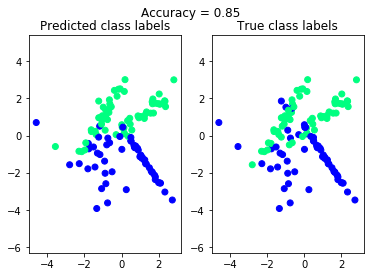

In [20]:
X, y = make_classification(n_features=2, n_redundant=0, n_samples=400,
                          random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=RANDOM_STATE)
#

clf = DecisionTree(max_depth=4, criterion='gini')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
prob_pred = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

if (sum(np.argmax(prob_pred,axis=1) - y_pred) == 0):
    print('predict_proba works!')

plt.suptitle("Accuracy = {0:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.winter)
plt.title('Predicted class labels')
plt.axis('equal')
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.winter)
plt.title('True class labels')
plt.axis('equal');